In [53]:

import cv2
from PIL import Image, ImageDraw, ImageFont, ImageTransform
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
from glob import glob
import sys

import os
from configparser import ConfigParser
path_config_file = os.getcwd().split('docrv2_sroie')[0] + 'docrv2_sroie/' + 'config.ini'
common_variable = ConfigParser()
common_variable.read(path_config_file)
print(common_variable.sections())
print(common_variable['database']['module_path'])
sys.path.append(common_variable['database']['module_path'])
from db_util import *
from db import *
from random import choice, randrange

['database', 'mlflow', 'font']
/media/myungsungkwak/msdisk/docrv2_sroie/modules/database/


In [5]:
# set simulator data
fontdir = '../../../data/font/*.ttf'
fontpath = glob(fontdir)
noisefontdir = '../../../data/font/handfont/*.ttf'
noisefontpath = glob(noisefontdir)

textdata = pd.read_csv('../../../data/textdata.csv',sep=',',header=None)
textdata = list(textdata.values)

In [9]:
# set data path 
datadir = '/home/dk/docrv2_sroie/data/test_task12_img'
datapath = glob(datadir+'/*.jpg')

In [13]:
# set simulator parameter
imageSize = (256, 256)
fontsSize = (10,30)

In [47]:
# some generators
def cropImage(img, imageSize, numImage):
    x, y = img.size
    sample_list = []
    for idx in range(numImage):
        x1 = randrange(0, x - imageSize[0])
        y1 = randrange(0, y - imageSize[1])
        sample_list.append(img.crop((x1, y1, x1 + imageSize[0], y1 + imageSize[1])))
    return sample_list

def fontGenerator(fontpath, fontsSize):
    while True:
        fontselection = np.random.randint(0,len(fontpath),1)[0]
        fontsize = np.random.randint(fontsSize[0],fontsSize[1],1)[0]
        yield ImageFont.truetype(fontpath[fontselection], fontsize)
fontgen = fontGenerator(fontpath, fontsSize)

def noiseFontGenerator(fontpath, fontsSize):
    while True:
        fontselection = np.random.randint(0,len(fontpath),1)[0]
        fontsize = np.random.randint(fontsSize[0],fontsSize[1],1)[0]
        yield ImageFont.truetype(noisefontpath[fontselection], fontsize*2)
noisefontgen = noiseFontGenerator(noisefontpath, fontsSize)

def randcapitalize(text):
    return ''.join(choice((str.upper, str.lower))(c) for c in text)

def textGenerator(textdata):
    while True:
        textselection = np.random.randint(0,len(textdata),1)[0]
        randchoice = np.random.randint(0,10,1)[0]
        if randchoice <= 2:
            yield str(textdata[textselection]) 
        elif randchoice > 2 and randchoice < 8:
            yield str(textdata[textselection]).lower()
        else:
            yield randcapitalize(str(textdata[textselection]))
textgen = textGenerator(textdata[0])

def noiseTextGenerator(textdata):
    while True:
        textselection = np.random.randint(0,len(textdata),1)[0]
        ttext = str(textdata[textselection])
        stext = ''.join(choice(ttext) for _ in range(np.random.randint(0,5,1)[0]))
        yield randcapitalize(stext)
noisetextgen = noiseTextGenerator(textdata[0])

def locGenerator(imageSize):
    while True:
        x = np.random.randint(imageSize[0]//8,imageSize[0]//4,1)[0]
        y = np.random.randint(imageSize[1]//8,imageSize[1]//4,1)[0]
        yield [x,y]
locgen = locGenerator(imageSize)

def textcoordinates(font, text, loc):
    char_table = pd.DataFrame({'x1':[], 'y1':[], 'x2':[], 'y2':[], 'x3':[], 'y3':[],
                                     'x4':[], 'y4':[], 'char':[]})
    for i, char in enumerate(text):
        b1 = font.getsize('A')[1]
        r, b2 = font.getsize(text[:i+1])
        b = b1 if b1 < b2 else b2
        w, _ = font.getmask(char).size
        _, h = font.getmask('A').size
        r += loc[0]
        b += loc[1]
        t = b - h
        l = r - w
        right = int(np.round(r))
        bottom = int(np.round(b))
        top = int(np.round(t))
        left = int(np.round(l))
        if i == 0:
            char_data = pd.DataFrame({'x1':[left-2], 'y1':[top], 
                                     'x2':[left-2], 'y2':[top],
                                     'x3':[left-2], 'y3':[bottom],
                                     'x4':[left-2], 'y4':[bottom], 'char':' '})
            char_table = char_table.append(char_data, ignore_index=True)
        if text[i] != ' ':
            char_data = pd.DataFrame({'x1':[left], 'y1':[top], 
                                     'x2':[right], 'y2':[top],
                                     'x3':[right], 'y3':[bottom],
                                     'x4':[left], 'y4':[bottom], 'char':text[i]})
            char_table = char_table.append(char_data, ignore_index=True)
        if i == len(text)-1:
            char_data = pd.DataFrame({'x1':[right+2], 'y1':[top], 
                                     'x2':[right+2], 'y2':[top],
                                     'x3':[right+2], 'y3':[bottom],
                                     'x4':[left+2], 'y4':[bottom], 'char':' '})
            char_table = char_table.append(char_data, ignore_index=True)
            
        char_table.x1 = char_table.x1.astype(int)
        char_table.y1 = char_table.y1.astype(int)
        char_table.x2 = char_table.x2.astype(int)
        char_table.y2 = char_table.y2.astype(int)
        char_table.x3 = char_table.x3.astype(int)
        char_table.y3 = char_table.y3.astype(int)
        char_table.x4 = char_table.x4.astype(int)
        char_table.y4 = char_table.y4.astype(int)
    return char_table

def snpnoisy(image):
    image = np.array(image)
    row,col,ch = image.shape
    s_vs_p = 0.5
    amount = 0.004
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
          for i in image.shape]
    out[coords] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
          for i in image.shape]
    out[coords] = 0
    return Image.fromarray(out)

def create_image():
    # create image
    img_clean = Image.new('RGB', imageSize, color='White')
    draw_clean = ImageDraw.Draw(img_clean)
    
    # first text
    font = next(fontgen)
    text = next(textgen)
    loc = next(locgen)
    draw_clean.text(loc, text, fill=(0,0,0), font=font)
    tb = textcoordinates(font, text, loc)

    # second text
    loc[1] = tb['y4'].values[-1]+10
    font = next(fontgen)
    text = next(textgen)
    draw_clean.text(loc, text, fill=(0,0,0), font=font)
    tb = tb.append(textcoordinates(font, text, loc))
    
    # add line
    if choice((0,1,2,3,4,5,6,7,8))==0:
        draw_clean.line((0,loc[1],imageSize[0],loc[1]),fill=tuple(np.random.randint(0,10,3)), width=np.random.randint(2,5,1)[0])
        draw_clean.line((0,loc[1]*2,imageSize[0],loc[1]*2),fill=tuple(np.random.randint(0,10,3)), width=np.random.randint(2,5,1)[0])
    if choice((0,1,2,3,4,5,6,7,8))==0:
        draw_clean.text((0,loc[1]/2*3), '-'*100, fill=tuple(np.random.randint(0,10,3)), font=font)
        draw_clean.text((0,imageSize[1]-loc[1]/2*3), '-'*100, fill=tuple(np.random.randint(0,10,3)), font=font)
    if choice((0,1,2,3,4,5,6,7,8))==0:
        draw_clean.text((0,loc[1]/2*3), '='*100, fill=tuple(np.random.randint(0,10,3)), font=font)
    if choice((0,1,2,3,4,5,6,7,8))==0:
        draw_clean.text((0,loc[1]/2*3), '- '*100, fill=tuple(np.random.randint(0,10,3)), font=font)

    return img_clean

def createImage(numImage):
    imglist = []
    for _ in range(numImage):
        imglist.append(create_image())
    return(imglist)

def getImage(path):
    img = Image.open(path)
    x, y = img.size
    if x > 512:
        img = img.resize((x//2, y//2))
    return img

In [32]:
numImage = 10

fabimgs = createImage(numImage)
cropimgs = cropImage(img, imageSize, numImage)

In [51]:
path = '/home/dk/docrv2_sroie/DB/'
name = 'style_B'
label = 'style'
numImage = 100
cache = {}

db_data = create_data_db(path=path, name=name, description='datadb_cyclegan',data_class=label)
db_data_db = db_data.open_db(b'db_data')
ind = 0
for idx in tqdm(range(numImage)):
    img = create_image()
    cache = update_cache(cache, index=idx, label=label, ref=label, image=img)
    if idx % 5000 == 0:
        write_cache_to_db(db_data, db_data_db, cache)
        cache = {}
        
write_cache_to_db(db_data, db_data_db, cache)
cache = {}
#refresh_main_db()


100%|██████████| 100/100 [00:04<00:00, 24.89it/s][A


In [48]:
for cidx in tqdm(range(len(datapath))):
    filepath = datapath[cidx]
    path = '/home/dk/docrv2_sroie/DB/'
    name = 'style_real_%05d'%cidx
    label = 'style'
    numImage = 5000
    cache = {}

    db_data = create_data_db(path=path, name=name, description='datadb_cyclegan',data_class=label)
    db_data_db = db_data.open_db(b'db_data')
    oimg = getImage(filepath)
    imgs = cropImage(oimg, imageSize, numImage)
    #print(cidx,'/',len(datapath),'=',name)
    for idx in range(numImage):
        img = imgs[idx]
        cache = update_cache(cache, index=idx, label=label, ref=filepath, image=img)
        if idx % 2000 == 0:
            write_cache_to_db(db_data, db_data_db, cache)
            cache = {}

    write_cache_to_db(db_data, db_data_db, cache)
    cache = {}



 86%|████████▌ | 309/360 [35:05<05:09,  6.07s/it]


100%|██████████| 360/360 [40:53<00:00,  6.82s/it]


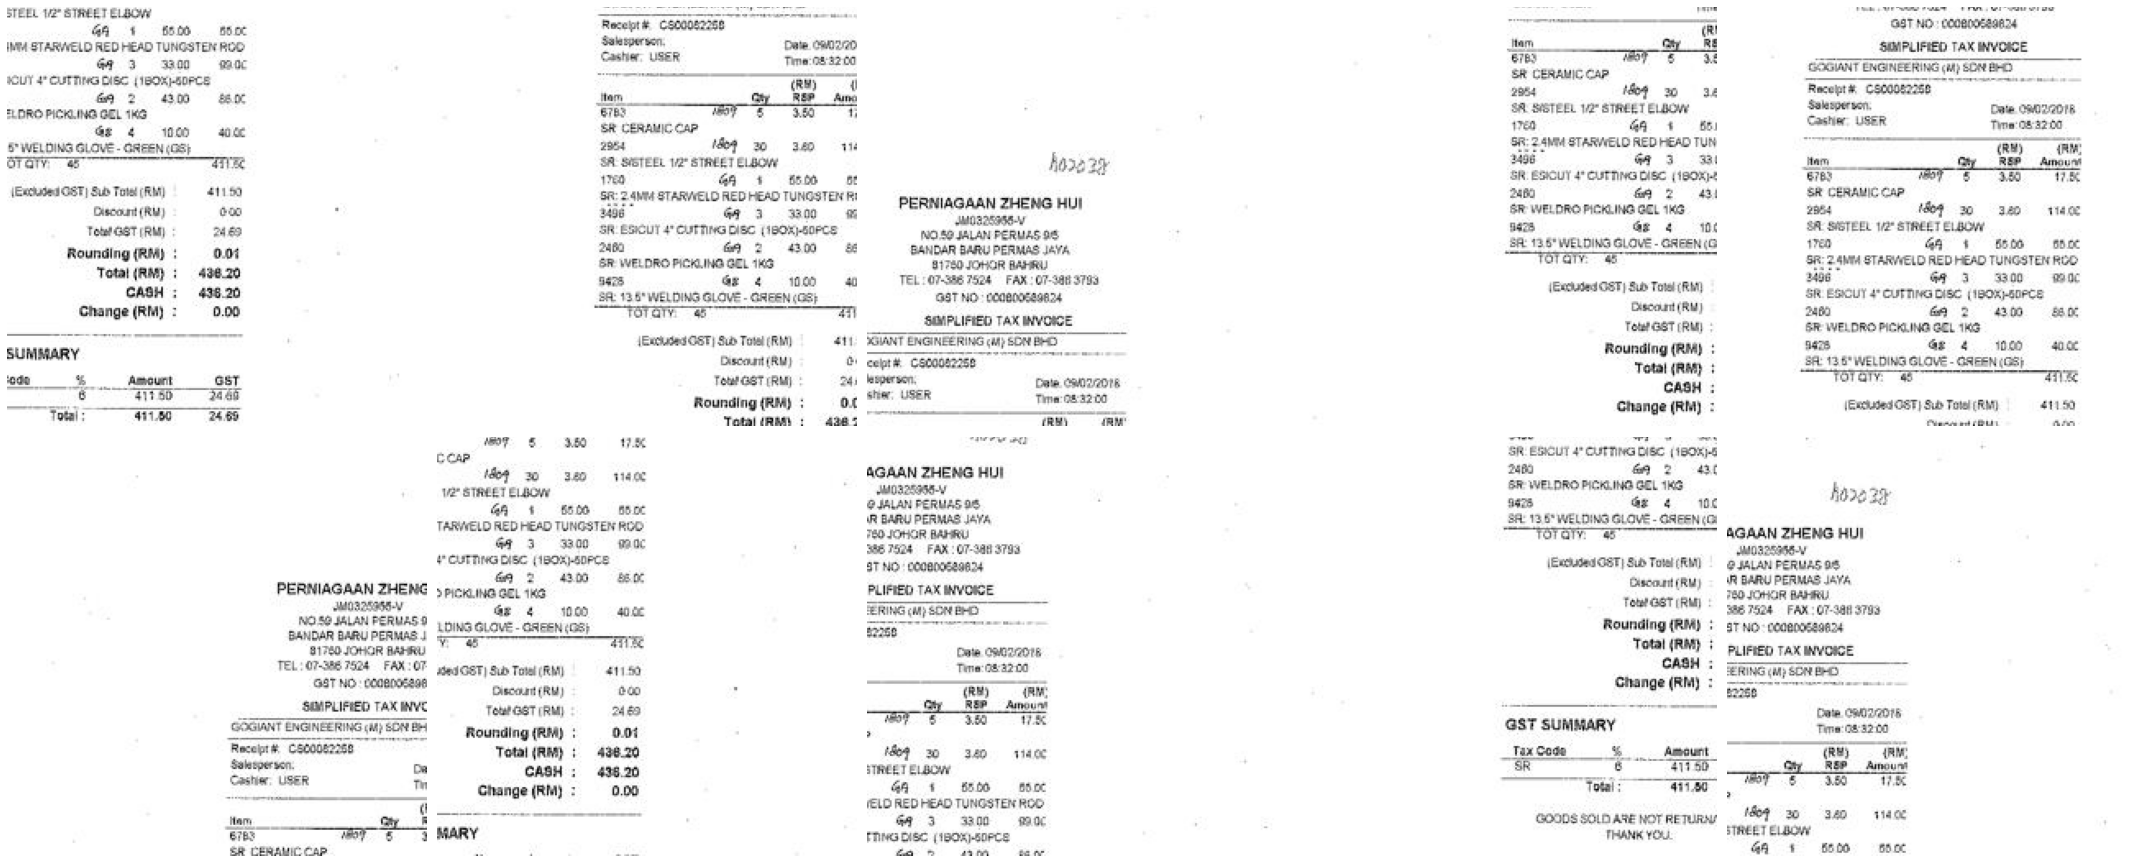

In [54]:
def show_images_in_db(db_name,
                      db_base=common_variable['database']['DB_BASE'],
                      prefix='img',
                      show_imgs_count=10,
                      enable_db_info=False):
    target_db_path = os.path.join(db_base, db_name)
    target_db = open_env(target_db_path)

    if enable_db_info:
        print_env(target_db)
        print_db(target_db)

    imgs = read_bulk_data_from_db(target_db, prefix='img')
    imgs_len = len(imgs)
    # or
    # imgs_length = show_imgs_count

    rows = 5
    cols = 5
    axes = []
    fig = plt.figure(figsize=(30,30))
    
    idx = 0
    for idx in range(imgs_len):
        axes.append(fig.add_subplot(rows, cols, idx+1))
        plt.axis('off')
        plt.imshow(imgs[idx])
    
    fig.tight_layout()
    plt.show()

show_images_in_db('style_real_00004')

In [52]:
refresh_main_db()

+------------------------------+-------------------------------------------------------+
| Key                          | Value                                                 |
+------------------------------+-------------------------------------------------------+
| d2gan_test_1                 | /home/dk/docrv2_sroie/DB/d2gan_test_1                 |
| d2gan_test_100               | /home/dk/docrv2_sroie/DB/d2gan_test_100               |
| d2gan_test_1000              | /home/dk/docrv2_sroie/DB/d2gan_test_1000              |
| d2gan_train_100000           | /home/dk/docrv2_sroie/DB/d2gan_train_100000           |
| denoise_test_100             | /home/dk/docrv2_sroie/DB/denoise_test_100             |
| denoise_train_100000_nostyle | /home/dk/docrv2_sroie/DB/denoise_train_100000_nostyle |
| recog_test_1                 | /home/dk/docrv2_sroie/DB/recog_test_1                 |
| recog_test_1000              | /home/dk/docrv2_sroie/DB/recog_test_1000              |
| recog_train_100000 

['style_real_00293',
 'style_real_00092',
 'style_real_00217',
 'style_real_00347',
 'style_real_00250',
 'style_real_00342',
 'style_real_00190',
 'style_real_00245',
 'style_real_00060',
 'style_real_00358',
 'style_real_00077',
 'style_real_00009',
 'style_real_00201',
 'style_real_00355',
 'style_real_00325',
 'style_real_00279',
 'style_real_00089',
 'style_real_00268',
 'style_real_00085',
 'style_real_00082',
 'style_real_00316',
 'style_real_00163',
 'style_real_00137',
 'style_real_00155',
 'denoise_train_100000_nostyle',
 'style_real_00308',
 'style_real_00213',
 'style_real_00255',
 'style_real_00298',
 'style_real_00220',
 'style_real_00045',
 'style_real_00047',
 'style_real_00334',
 'style_real_00132',
 'style_real_00254',
 'style_real_00134',
 'style_real_00295',
 'style_real_00108',
 'style_real_00246',
 'style_real_00062',
 'style_real_00196',
 'style_real_00176',
 'style_real_00167',
 'style_real_00257',
 'style_real_00117',
 'style_real_00345',
 'style_real_00235',
 

(10, 128, 256, 3)

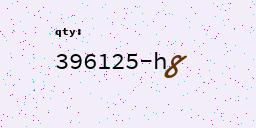